In [ ]:
# Name: Sitong Mu; Github username: edsml-sm1122

The file train a new MLP model based on the fist 80% of storm event (tracks) and test the model both on the whole dataset and the last 20% storm event.

In [1]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 25.0 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from livelossplot import PlotLosses
from pycm import *
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# to import utilitis
import sys
sys.path.insert(0,'/content/drive/MyDrive/IRP/codefinal')
from utilities import *

In [5]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [6]:
#read data, feature engineering, normalization, reshaping

#track, time(1800s), space(0.01degree,~1km), ['MWD','PWP','SWH','TWD','WiD','WiS']
m25 = np.load('/content/drive/MyDrive/IRP/data/structured/DepthContour25m.npy')
m25 = np.delete(m25, (45,83,77),axis=0)
print(f"Feature before reshaping: {np.shape(m25)}")

m0 = np.load('/content/drive/MyDrive/IRP/data/structured/Coastline0p01.npy')
m0 = np.delete(m0, (45,83,77),axis=0)
# for each trach, each parameter, the first timestep data is just the index of the stations
m25 = m25[:,1:,:,:]
m0 = m0[:,1:,:,:]

#tar is SWH at coastline
tar = m0[:,:,:,2]
tar[np.isnan(tar)] = 0
print(f"Target before reshaping: {np.shape(tar)}")

#reshape target and features (track and time dim)
tar_rs = np.reshape(tar, (np.shape(tar)[0]*np.shape(tar)[1],np.shape(tar)[2]))
print(f"Target after reshaping (also Target final): {np.shape(tar_rs)}")

feature25m = np.reshape(m25, (np.shape(m25)[0]*np.shape(m25)[1],np.shape(m25)[2],np.shape(m25)[3]))
print(f"Feature after reshaping: {feature25m.shape}")

# convert 2 degree dimentions to sin and cos, now the third dimention is ['sin(MWD)',cos(MWD),'PWP','SWH','TWD',sin('WiD'),cos(WiD),'WiS']
feature25m = convert_deg_to_sin_cos(feature25m)
print('Feature after FE:', feature25m.shape)

#reshape sapce and parameters to 1d to deef into model
feature25m = feature25m.reshape(feature25m.shape[0],feature25m.shape[1]*feature25m.shape[2])
mean25m,std25m,feature25m = normalize(feature25m)
print('Feature final: ', feature25m.shape)

Feature before reshaping: (185, 98, 155, 6)
Target before reshaping: (185, 97, 145)
Target after reshaping (also Target final): (17945, 145)
Feature after reshaping: (17945, 155, 6)
Feature after FE: (17945, 155, 8)
Feature final:  (17945, 1240)


In [8]:
# train test split by tracks (actually by flatted (track,time), but no difference as the track number*0.8 is an integer)

split = int((len(tar_rs)*0.8))
X_train,y_train = feature25m[:split,:], tar_rs[:split,:]
X_test,y_test = feature25m[split:,:], tar_rs[split:,:]

traindata = MLPDataset(X_train,y_train)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
valdata = MLPDataset(X_test,y_test)

In [9]:
# set_seed(seed)
seed = 42
lr = 1e-4
# momentum = 0.9
batch_size = 64
test_batch_size = 1000


model = simpleFFN().to(device)                                              # instantiate model and send it to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)   # instantiate the optimizer
# optimizer = torch.optim.Adam(model.parameters(),momentum=momentum)   # instantiate the optimizer
criterion = nn.MSELoss()

In [10]:
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
validation_loader = DataLoader(valdata, batch_size=test_batch_size, shuffle=False, num_workers=0)
# test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

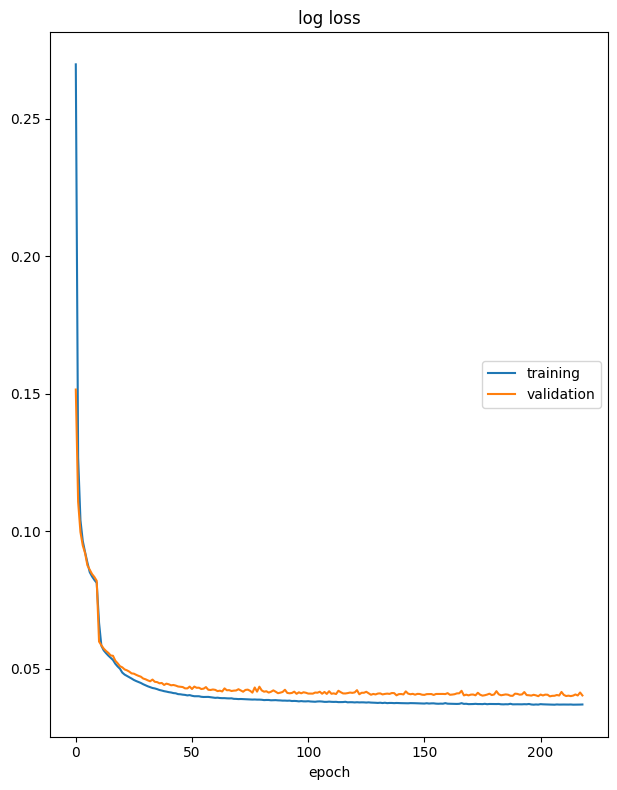

log loss
	training         	 (min:    0.037, max:    0.270, cur:    0.037)
	validation       	 (min:    0.040, max:    0.152, cur:    0.040)
0.04028827324509621


KeyboardInterrupt: ignored

In [ ]:
# built in lr (e-4)
# the keyboard interrupt as the loss has not been changing (to a accuracy of 0.001) for 50 epochs
n_epochs = 500

liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(n_epochs):
    logs = {}
    train_loss= torch.sqrt(mlptrain(model, optimizer, criterion, train_loader,device=device))

    logs['' + 'log loss'] = train_loss.item()
    # logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss= torch.sqrt(mlpvalidate(model, criterion, validation_loader,device=device))
    logs['val_' + 'log loss'] = validation_loss.item()
    # logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

In [ ]:
torch.save(model, '/content/drive/MyDrive/IRP/model/MLP25m20pertrackunseen.npy')

In [ ]:
#based on all data
mlptrack = torch.load('/content/drive/MyDrive/IRP/model/MLP25m20pertrackunseen.npy')

res = mlptrack(torch.tensor(feature25m).float().to(device))
res = res.cpu().detach().numpy()

res = res.flatten()
tar = tar_rs.flatten()

calculate_metrics(tar, res)

{'Bias': -0.001657918194261747,
 'RMSE': 0.0375569278123308,
 'Scatter Index': 0.23821744476303316,
 'Correlation Coefficient': 0.9953458930762442,
 'Coefficient of Efficiency': 0.9906948234702116,
 'Index of Agreement': 0.9976593238196158,
 'MAE': 0.015993192155803842}

In [ ]:
# test data
res = mlptrack(torch.tensor(X_test).float().to(device))
res = res.cpu().detach().numpy()

res = res.flatten()
tar = y_test.flatten()

calculate_metrics(tar, res)

{'Bias': -0.0013681120827505225,
 'RMSE': 0.04053860161205527,
 'Scatter Index': 0.24708301795982657,
 'Correlation Coefficient': 0.9949767516604733,
 'Coefficient of Efficiency': 0.9899380659973973,
 'Index of Agreement': 0.9974795143715501,
 'MAE': 0.016931528743928073}